# Trabajo Práctico 1: Enunciado


El trabajo práctico 1 de la materia se basa en el análisis de los tweets del set de datos de la competencia: https://www.kaggle.com/c/nlp-getting-started.  

- id - identificador unico para cada  tweet
- text - el texto del tweet
- location - ubicación desde donde fue enviado (podría no estar)
- keyword - un keyword para el tweet  (podría faltar)
- target - en train.csv, indica si se trata de un desastre real  (1) o no (0)

El objetivo del primer TP es realizar un análisis exploratorio del set de datos. Queremos ver qué cosas podemos descubrir sobre los datos que puedan resultar interesantes. Estas cosas pueden estar relacionadas al objetivo del TP2 (predecir si un cierto tweet es real o no) o no, ambas son de interés.

Los requisitos de la primera entrega son los siguientes:

- El análisis debe estar hecho en Python Pandas o R.
- El análisis debe entregarse en formato pdf vía gradescope. En el informe no va código.
- Informar el link a un repositorio Github en donde pueda bajarse el código completo para generar el análisis.

La evaluación del TP se realizará en base al siguiente criterio:

- Originalidad del análisis exploratorio. 
- Calidad del reporte. ¿Está bien escrito? ¿Es claro y preciso? 
- Calidad del análisis exploratorio: qué tipo de preguntas se hacen y de qué forma se responden, ¿es la respuesta clara y concisa con respecto a la pregunta formulada? 
- Calidad de las visualizaciones presentadas.
  - ¿Tienen todos los ejes su rótulo?
  - ¿Tiene cada visualización un título?
  - ¿Es entendible la visualización sin tener que leer la explicación?
  - ¿El tipo de plot elegido es adecuado para lo que se quiere visualizar?
  - ¿Es una visualización interesante?
  - ¿El uso del color es adecuado?
  - ¿Hay un exceso o falta de elementos visuales en la visualización elegida?
  - ¿La visualización es consistente con los datos?
- Conclusiones presentadas.


In [ ]:
# Instalación de librerías a usar
# para escapear html
!pip install bs4
# para normalización del texto
!pip install nltk
!pip install stopwords
# visualización nube de palabras
!pip install wordcloud

In [383]:
# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import string

from nltk.tokenize import sent_tokenize
from bs4 import BeautifulSoup
from html import unescape
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from collections import Counter
#Para generar una paleta de colores equivalente a cubehelix(sns) en matplotlib
from matplotlib.colors import ListedColormap

%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

#Nueva paleta de colores para matplotlib
color_hex_arr = ["#2B6F39", "#C2D8F2","#182D48","#A1784A","#D38FC5"]
cubehelix_map = ListedColormap(sns.color_palette(color_hex_arr).as_hex())

warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alejandro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/alejandro/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/alejandro/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/alejandro/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [384]:
tweets = pd.read_csv('../data/train.csv', encoding='utf-8')
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


## Agregado de nuevas columnas y limpieza del dataset

In [385]:
# primera normalización del texto, pasamos a lowercase 
tweets['normalized_text'] = tweets.text.str.lower()
# solo para facilitar algunas visualizaciones
tweets['target_name']= np.where(tweets['target']==1 ,'SI','NO')

### Normalización del texto y nuevas columnas a partir del texto

#### Eliminamos los links del texto normalizado y guardamos los links en una columna a parte por si sirven a futuro

In [386]:
URLPATTERN = r'(https?://\S+)' 

tweets['urls'] = tweets.normalized_text.apply(lambda x: re.findall(URLPATTERN, x))
tweets['normalized_text'] = tweets.normalized_text.apply(lambda x: re.sub(URLPATTERN,"", x))
# cuento la cantidad de links en los tweets
tweets['url_count'] = tweets.urls.str.len()

#### Eliminamos los hashtags del texto normalizado y lo dejamos en otra columna junto con el count

In [387]:
# cuento la cantidad de hashtags en los tweets
# nueva columna con el total de hashtags, y los hashtags
tweets['hashtags'] = tweets.normalized_text.apply(lambda x: re.findall(r"#(\w+)", x))
tweets['hashtags_count'] = tweets.hashtags.str.len()
tweets['normalized_text'] = tweets.normalized_text.apply(lambda x: re.sub(r"#(\w+)","", x))

#### Eliminamos los tags del texto y lo dejamos en otra columna junto con el count

In [388]:
# cuento la cantidad de ags en los tweets
# nueva columna con el total de tags, y los tags
tweets['tags'] = tweets.text.str.lower().apply(lambda x: re.findall(r"@(\w+)", x))
tweets['normalized_text'] = tweets.normalized_text.apply(lambda x: re.sub(r"@(\w+)","", x))
tweets['tags_count'] = tweets.tags.str.len()

#### Contamos cantidad de oraciones

In [389]:
tweets['sentences_count'] = tweets.normalized_text.apply(lambda x : len(sent_tokenize(x))) 

#### Eliminamos signos de puntuación y html

In [390]:
translator = str.maketrans('', '', string.punctuation) 
# !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~

def remove_punctuation(text):        
    return text.translate(translator)

In [391]:
def remove_htmlsymbols(text):
    soup = BeautifulSoup(unescape(text))
    return soup.text

In [392]:
#Emoji patterns
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

def remove_emojis_non_ascii(text):    
    #replace consecutive non-ASCII characters with a space
    result = re.sub(r'[^\x00-\x7F]+',' ', text)
    #remove emojis from tweet
    result = emoji_pattern.sub(r'', result)    
    return result

In [393]:
tweets['normalized_text'] = tweets.normalized_text.apply(remove_htmlsymbols)
tweets['normalized_text'] = tweets.normalized_text.apply(remove_punctuation)
tweets['normalized_text'] = tweets.normalized_text.apply(remove_emojis_non_ascii)

#### Eliminamos stop words y creamos nueva columna con array de palabras

In [394]:
# convertimos el texto en listado de palabras y despues borramos las stop words
tweets['words'] = tweets.normalized_text.str.split()
stop_words = stopwords.words('english')
tweets['normalized_words'] = tweets['words'].apply(lambda x: [item for item in x if item not in stop_words])
# eliminar las stop words del texto normalizado
tweets['normalized_text'] = [' '.join(map(str, l)) for l in tweets['normalized_words']]
# vemos como queda el dataset
tweets.head()

,id,keyword,location,text,target,normalized_text,target_name,urls,url_count,hashtags,hashtags_count,tags,tags_count,sentences_count,words,normalized_words
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason may allah forgive us,SI,[],0,[earthquake],1,[],0,1,"[our, deeds, are, the, reason, of, this, may, ...","[deeds, reason, may, allah, forgive, us]"
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,SI,[],0,[],0,[],0,2,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...,SI,[],0,[],0,[],0,2,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive evacuation orders california,SI,[],0,[wildfires],1,[],0,1,"[13000, people, receive, evacuation, orders, i...","[13000, people, receive, evacuation, orders, c..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby smoke pours school,SI,[],0,"[alaska, wildfires]",2,[],0,1,"[just, got, sent, this, photo, from, ruby, as,...","[got, sent, photo, ruby, smoke, pours, school]"


#### Contador de palabras y frecuencia de aparición

In [395]:
# contamos la cantidad de palabras de cada tweet
tweets['words_counter'] = tweets.normalized_words.apply(Counter)
# me quedo con las palabras que mas ocurrencias tienen en cada row
tweets['word_max_appearance'] = tweets.words_counter.apply( lambda x: max(x) if x else None)  
tweets['word_max_appearance_count'] =  tweets.words_counter.apply( lambda x: max(x.values()) if x else 0)

#### Analizamos si el texto tiene números y guardamos el dato en una nueva columna

In [396]:
# esto chequea números como 1,2 y tambíen escrito como one, two
def existence_of_numeric_data(text):
    text=nltk.word_tokenize(text)
    pos = nltk.pos_tag(text)
    count = 0
    for i in range(len(pos)):
        word , pos_tag = pos[i]
        if pos_tag == 'CD':
            return 1
    return 0

In [397]:
# con 1 si tiene , 0 sino
tweets['has_numbers'] = tweets.normalized_text.apply(existence_of_numeric_data)

#### Limpio la columna location de caracteres inválidos

In [398]:
tweets['location'] = tweets.location.str.replace('$','')

### Normalización de la columna keyword

In [399]:
# eliminamos "%20" que representa espacio
tweets['keywords'] = tweets.keyword.str.replace('%20',' ')

### Correccion tipo de datos en keyword/location para optimizacion de memoria.

In [400]:
for col in ['keyword', 'location']:
    tweets[col] = tweets[col].astype('category')
#check de tipos de datos categoricos 
tweets.dtypes

id                              int64
keyword                      category
location                     category
text                           object
target                          int64
normalized_text                object
target_name                    object
urls                           object
url_count                       int64
hashtags                       object
hashtags_count                  int64
tags                           object
tags_count                      int64
sentences_count                 int64
words                          object
normalized_words               object
words_counter                  object
word_max_appearance            object
word_max_appearance_count       int64
has_numbers                     int64
keywords                       object
dtype: object

### Agregado de columna para indicar si tiene o no location


In [401]:
#true si tiene location, false si no
tweets['has_location'] = ~tweets['location'].isna()
tweets.head()

,id,keyword,location,text,target,normalized_text,target_name,urls,url_count,hashtags,...,tags_count,sentences_count,words,normalized_words,words_counter,word_max_appearance,word_max_appearance_count,has_numbers,keywords,has_location
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason may allah forgive us,SI,[],0,[earthquake],...,0,1,"[our, deeds, are, the, reason, of, this, may, ...","[deeds, reason, may, allah, forgive, us]","{'deeds': 1, 'reason': 1, 'may': 1, 'allah': 1...",us,1,0,NaN,False
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,SI,[],0,[],...,0,2,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","{'forest': 1, 'fire': 1, 'near': 1, 'la': 1, '...",sask,1,0,NaN,False
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...,SI,[],0,[],...,0,2,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","{'residents': 1, 'asked': 1, 'shelter': 2, 'pl...",shelter,2,0,NaN,False
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive evacuation orders california,SI,[],0,[wildfires],...,0,1,"[13000, people, receive, evacuation, orders, i...","[13000, people, receive, evacuation, orders, c...","{'13000': 1, 'people': 1, 'receive': 1, 'evacu...",receive,1,1,NaN,False
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby smoke pours school,SI,[],0,"[alaska, wildfires]",...,0,1,"[just, got, sent, this, photo, from, ruby, as,...","[got, sent, photo, ruby, smoke, pours, school]","{'got': 1, 'sent': 1, 'photo': 1, 'ruby': 1, '...",smoke,1,0,NaN,False


### Agregado de columnas para Análisis de sentimientos

In [402]:
sid = SentimentIntensityAnalyzer()

In [403]:
# Return a float for sentiment strength based on the input text. Positive values are positive valence, negative value are negative valence.
tweets['sentiment_score'] = tweets.normalized_text.apply(lambda x: sid.polarity_scores(x))
tweets['sentiment_score_compound'] = tweets.sentiment_score.apply(lambda x: x['compound'])
tweets['sentiment_score_pos'] = tweets.sentiment_score.apply(lambda x: x['pos'])
tweets['sentiment_score_neg'] = tweets.sentiment_score.apply(lambda x: x['neg'])

In [404]:
# vemos cómo queda el dataset
tweets.head()

,id,keyword,location,text,target,normalized_text,target_name,urls,url_count,hashtags,...,words_counter,word_max_appearance,word_max_appearance_count,has_numbers,keywords,has_location,sentiment_score,sentiment_score_compound,sentiment_score_pos,sentiment_score_neg
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason may allah forgive us,SI,[],0,[earthquake],...,"{'deeds': 1, 'reason': 1, 'may': 1, 'allah': 1...",us,1,0,NaN,False,"{'neg': 0.0, 'neu': 0.704, 'pos': 0.296, 'comp...",0.27,0.30,0.00
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,SI,[],0,[],...,"{'forest': 1, 'fire': 1, 'near': 1, 'la': 1, '...",sask,1,0,NaN,False,"{'neg': 0.286, 'neu': 0.714, 'pos': 0.0, 'comp...",-0.34,0.00,0.29
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...,SI,[],0,[],...,"{'residents': 1, 'asked': 1, 'shelter': 2, 'pl...",shelter,2,0,NaN,False,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.00,0.00,0.00
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive evacuation orders california,SI,[],0,[wildfires],...,"{'13000': 1, 'people': 1, 'receive': 1, 'evacu...",receive,1,1,NaN,False,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.00,0.00,0.00
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby smoke pours school,SI,[],0,"[alaska, wildfires]",...,"{'got': 1, 'sent': 1, 'photo': 1, 'ruby': 1, '...",smoke,1,0,NaN,False,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.00,0.00,0.00


### Quito NaNs de columna Location


In [405]:
if 'None' not in tweets['location'].value_counts():
    tweets['location'] = tweets['location'].cat.add_categories("None").fillna('None')
    
tweets['text_in_location'] = tweets[['text','location']].apply(lambda row: 'Existe' if row.location in row.text else 'No existe' ,axis = 1)

## Visualizaciones

### Cantidad de tweets Reales y Falsos (Target)

Text(0, 0.5, 'N° Tweets')

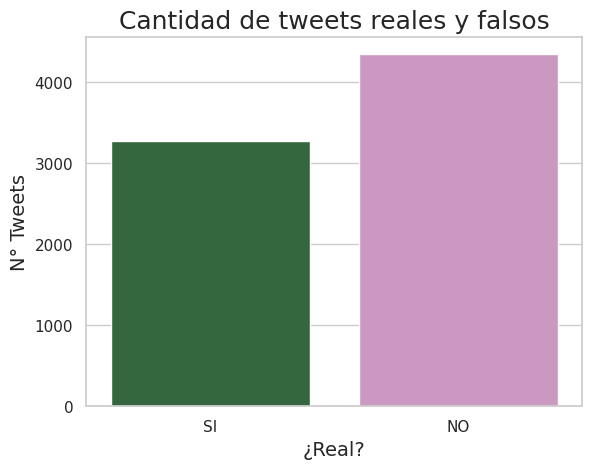

In [406]:

tweets_target = tweets[['id','target_name']].groupby('target_name').count().rename(columns={'id':'cantidad'})

# Grafico barplot
g = sns.barplot(x="target_name", y="cantidad", data=tweets_target.reset_index(),palette="cubehelix",order=['SI','NO'])
g.set_title("Cantidad de tweets reales y falsos", fontsize=18)
g.set_xlabel("¿Real?", fontsize=14)
g.set_ylabel("N° Tweets", fontsize=14)


### Cantidad de links

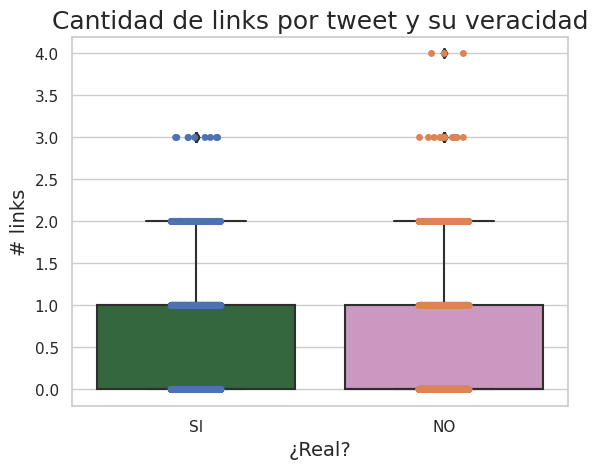

In [407]:
ax = sns.boxplot(x="target_name", y="url_count", data=tweets, palette="cubehelix")
ax = sns.stripplot(x="target_name", y="url_count", data=tweets) #scatterplot
ax.set_title("Cantidad de links por tweet y su veracidad", fontsize=18)
ax.set_xlabel("¿Real?", fontsize=14)
ax.set_ylabel("# links", fontsize=14)
plt.show()

El comportamiento parecería ser bastante similar en los tweets verdaderos que en los falsos con respecto a la cantidad de links que se utilizan, 
aunque se ven más anomalías en los tweets falsos. Para poder tener un mejor análisis realizamos a continuación un gráfico de densidad.

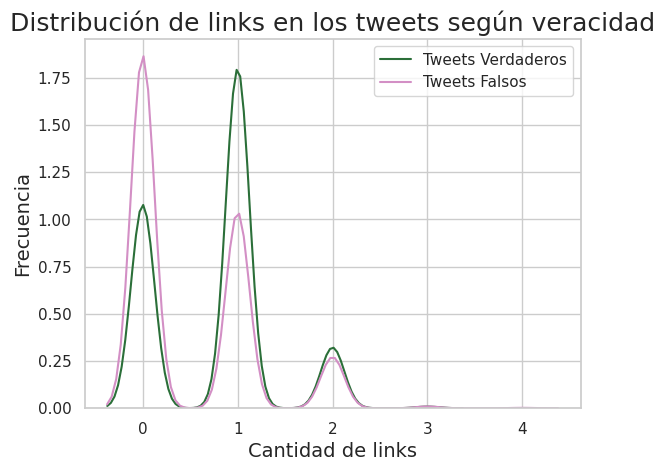

In [408]:
ax = sns.distplot( tweets[tweets['target'] == 1]['url_count'] , color=color_hex_arr[0], label="Tweets Verdaderos",hist=False)
ax = sns.distplot( tweets[tweets['target'] == 0]['url_count'] , color=color_hex_arr[4], label="Tweets Falsos",hist=False)
plt.legend()
ax.set_title("Distribución de links en los tweets según veracidad", fontsize=18)
ax.set_xlabel("Cantidad de links", fontsize=14)
ax.set_ylabel("Frecuencia", fontsize=14)
plt.show()

Al ver este gráfico podemos ver que los tweets que resultan falsos suelen tener menos links que los tweets verdaderos pero como ya vimos en el boxplot siguen habiendo anomalías donde tweets con 4 links resultan falsos esto lo terminamos de confirmar del todo en el siguiente plot de violin.

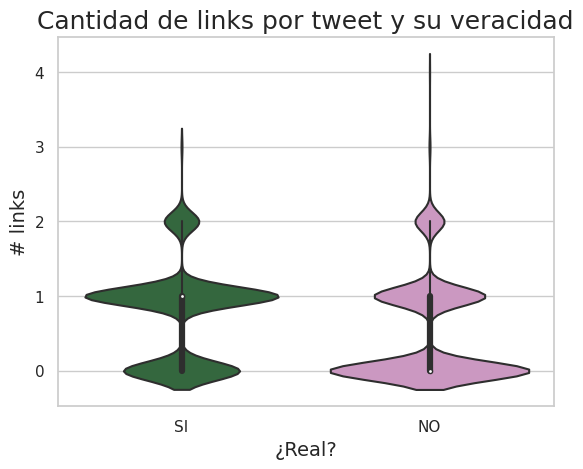

In [409]:
ax = sns.violinplot(x="target_name", y="url_count", data=tweets, palette="cubehelix")
ax.set_title("Cantidad de links por tweet y su veracidad", fontsize=18)
ax.set_xlabel("¿Real?", fontsize=14)
ax.set_ylabel("# links", fontsize=14)
plt.show()

Bajo la hipótesis de que el post sobre una catástrofe puede ir acompañado por datos numéricos (cantidad de heridos por ejemplo) decidimos analizar este 
dato en el texto. Este gráfico nos muestra que en general ya sean reales o no, los tweets no suelen tener datos numéricos. Por lo cual no nos aporta mucha
información para distinguir una categoría de la otra y descartamos este feature agregado.

### Análisis de hashtags

#### Cantidad de hashtags

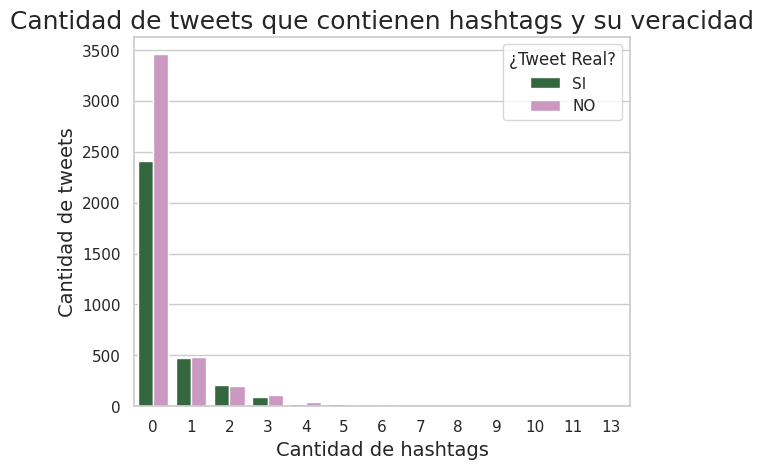

In [410]:
plot_hashtags_count = sns.countplot(x='hashtags_count',data=tweets,hue='target_name', palette="cubehelix")
plot_hashtags_count.set_title("Cantidad de tweets que contienen hashtags y su veracidad", fontsize=18)
plot_hashtags_count.set_xlabel("Cantidad de hashtags", fontsize=14)
plot_hashtags_count.set_ylabel("Cantidad de tweets", fontsize=14)
plot_hashtags_count.legend(loc='upper right', title='¿Tweet Real?')

En este gráfico podemos observar que en general los tweets no suelen usar demasiados hashtags y los que no usan ninguno son mayor % los falsos, por lo que 
en principio podemos ver que cuanto menos hashtags mejor para identificar un tweet falso.

#### Top 10 hashtags por categoría

In [411]:
hashtags_true = tweets[(tweets['target'] == 1) & (tweets['hashtags_count'] > 0)]['hashtags']
hashtags_false = tweets[(tweets['target'] == 0) & (tweets['hashtags_count'] > 0)]['hashtags']

In [412]:
hashtags_true_all = pd.value_counts(hashtags_true.apply(pd.Series).stack())
hashtags_false_all = pd.value_counts(hashtags_false.apply(pd.Series).stack())

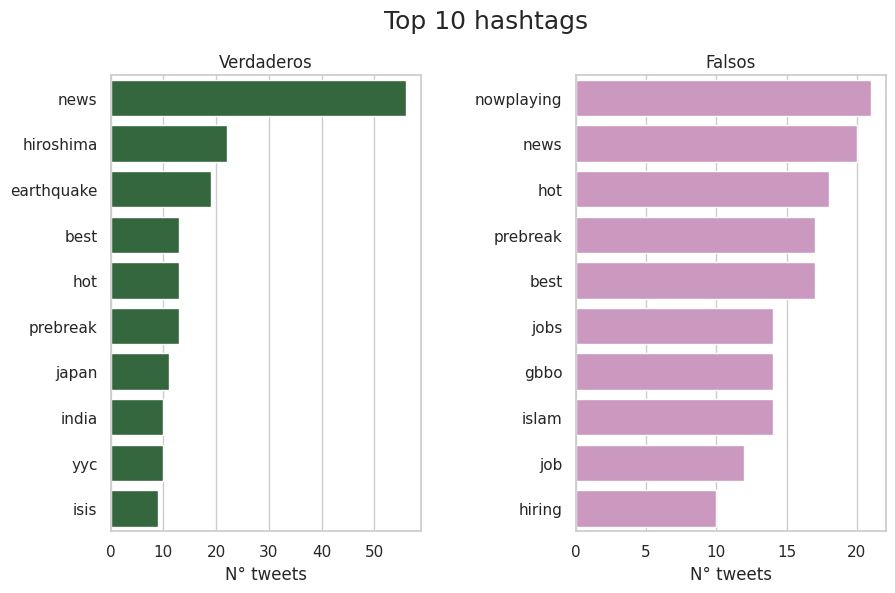

In [413]:
fig, ax =plt.subplots(1,2,figsize=(10,6))
sns.barplot(x=hashtags_true_all.head(10).values,y=hashtags_true_all.head(10).index,color=color_hex_arr[0],ax=ax[0],orient="h").\
    set(title = 'Verdaderos',xlabel='N° tweets')
sns.barplot(x=hashtags_false_all.head(10).values,y=hashtags_false_all.head(10).index,color=color_hex_arr[4],ax=ax[1],orient="h").\
    set(title = 'Falsos',xlabel='N° tweets')
fig.subplots_adjust(top=0.87,wspace = 0.5)
fig.suptitle('Top 10 hashtags', fontsize=18)
fig.show()

Los hashtags de news, best y hot se repiten en ambas categorías, predominando "news" en el set de datos verdaderos. El resto de los hashtags de tweets verdaderos (en su mayoría) tienen que ver con catastrófes mientras que los fakes no tienen nada que ver con esa temática (hay varios que hacen referencias a trabajos: jobs, job, hiring).

### Análisis de tags

#### Cantidad de tags

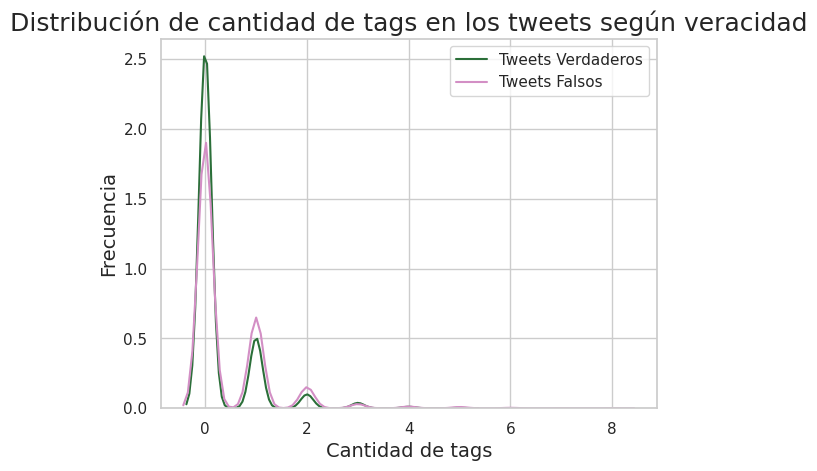

In [414]:
ax = sns.distplot( tweets[tweets['target'] == 1]['tags_count'] , label="Tweets Verdaderos",hist=False, color=color_hex_arr[0])
ax = sns.distplot( tweets[tweets['target'] == 0]['tags_count'] , label="Tweets Falsos",hist=False, color=color_hex_arr[4])
plt.legend()
ax.set_title("Distribución de cantidad de tags en los tweets según veracidad", fontsize=18)
ax.set_xlabel("Cantidad de tags", fontsize=14)
ax.set_ylabel("Frecuencia", fontsize=14)

plt.show()

Podemos observar que al igual que en los hashtags, en general no se usan muchos tags pero sí se usan un poco más en los tweets falsos que en los verdaderos.
Esto puede ser para conseguir más seguidores por ejemplo.

#### Top 10 tags por categoría

In [415]:
tags_true = tweets[(tweets['target'] == 1) & (tweets['tags_count'] > 0)]['tags']
tags_false = tweets[(tweets['target'] == 0) & (tweets['tags_count'] > 0)]['tags']

In [416]:
tags_true_all = pd.value_counts(tags_true.apply(pd.Series).stack())
tags_false_all = pd.value_counts(tags_false.apply(pd.Series).stack())

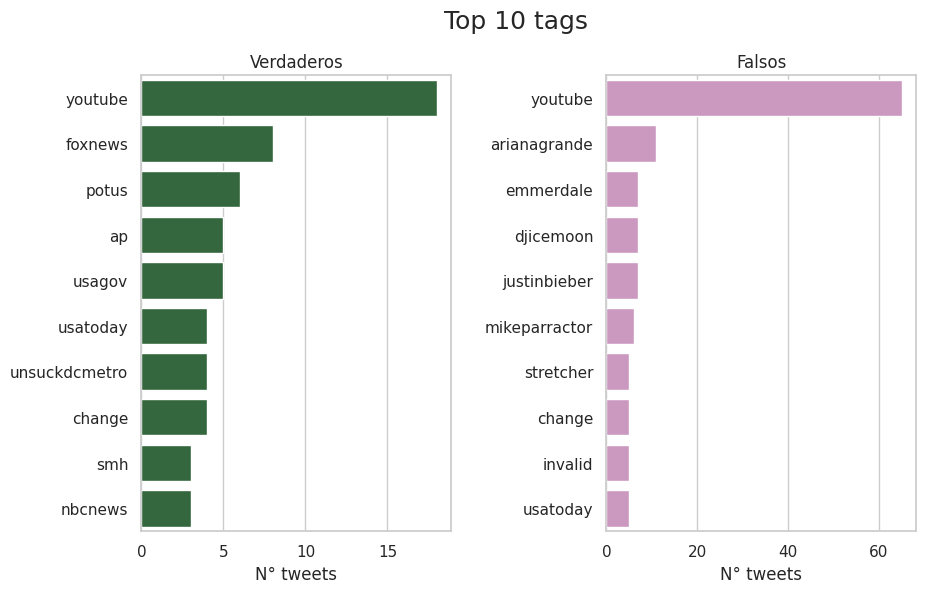

In [417]:
fig, ax =plt.subplots(1,2,figsize=(10,6))
sns.barplot(x=tags_true_all.head(10).values,y=tags_true_all.head(10).index,color=color_hex_arr[0],ax=ax[0],orient="h").\
    set(title = 'Verdaderos',xlabel='N° tweets')
sns.barplot(x=tags_false_all.head(10).values,y=tags_false_all.head(10).index,color=color_hex_arr[4],ax=ax[1],orient="h").\
    set(title = 'Falsos',xlabel='N° tweets')
fig.subplots_adjust(top=0.87,wspace = 0.5)
fig.suptitle('Top 10 tags', fontsize=18)
fig.show()

Al igual que con los hashtags, acá también algunos tags se repiten, como youtube, usatoday.
En los tweets verderos tenemos tags que hacen referencia a entidades del gobierno (como usagov) y medios de comunicación (como fox news, usatoday, unsuckdcmetro) mientras que en los falsos se hace referencia a artistas conocidos entre otras cosas.

### Cantidad de oraciones en el texto

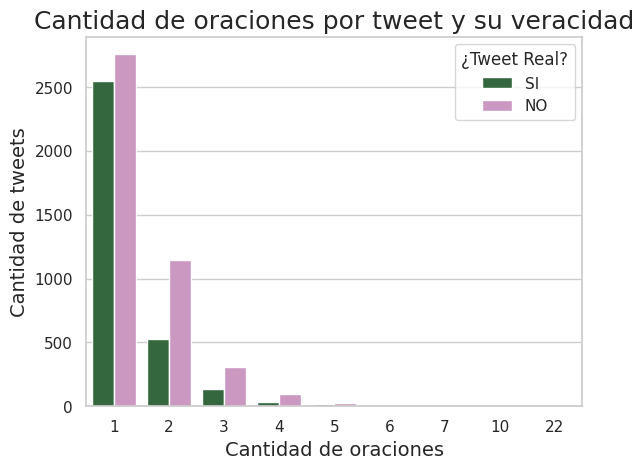

In [418]:
plot_sentences_count = sns.countplot(x='sentences_count',data=tweets,hue='target_name', palette="cubehelix")
plot_sentences_count.set_title("Cantidad de oraciones por tweet y su veracidad", fontsize=18)
plot_sentences_count.set_xlabel("Cantidad de oraciones", fontsize=14)
plot_sentences_count.set_ylabel("Cantidad de tweets", fontsize=14)
plot_sentences_count.legend(loc='upper right', title='¿Tweet Real?')

En este gráfico podemos observar que a medida que aumenta la cantidad de oraciones en los tweets hay mayor proporción de tweets verdaderos. Por lo cual podríamos 
decir que el "correcto armado" de una oración podría ser importante a la hora de analizar la veracidad del mismo.

### Análisis de cantidad de palabras y largo del texto
Analizo la cantidad de palabras (token_len) y lo analizo en relacion del largo del tweet (text_len Creo que daria el mismo resultado contando las palabras de Words o Normalized_words

Text(0.5, 1.0, 'Falsos')

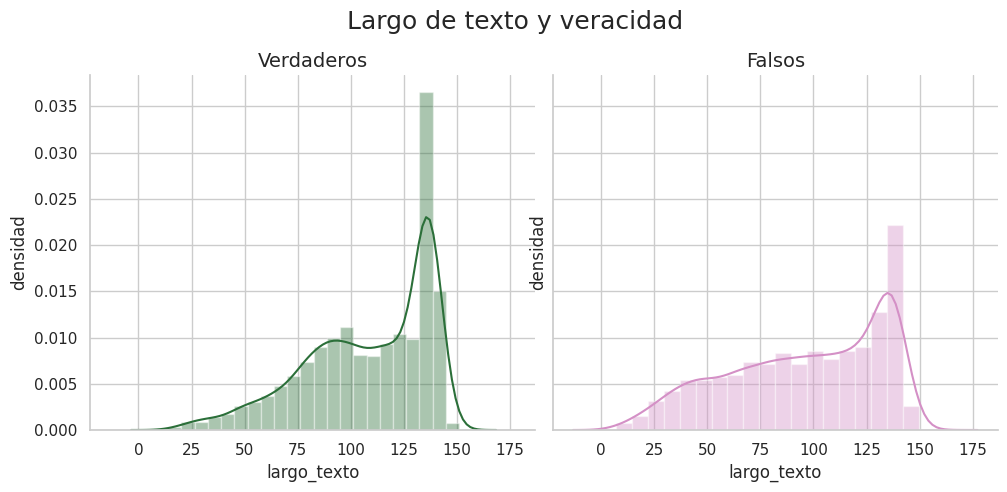

In [419]:
text_simple = pd.DataFrame()

text_simple['cantidad_palabras'] = tweets['text'].apply(lambda x: len([token for token in x.split()]))
text_simple['largo_texto'] = tweets['text'].apply(lambda x: len(x))
text_simple['estado'] = tweets['target_name']

g = sns.FacetGrid(text_simple, col="estado",height=5,hue='estado',palette='cubehelix')

g = g.map(sns.distplot, "largo_texto").set(ylabel="densidad")
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Largo de texto y veracidad', fontsize=18)
axes = g.axes.flatten()
axes[0].set_title("Verdaderos", fontsize=14)
axes[1].set_title("Falsos", fontsize=14)

#plt.show()


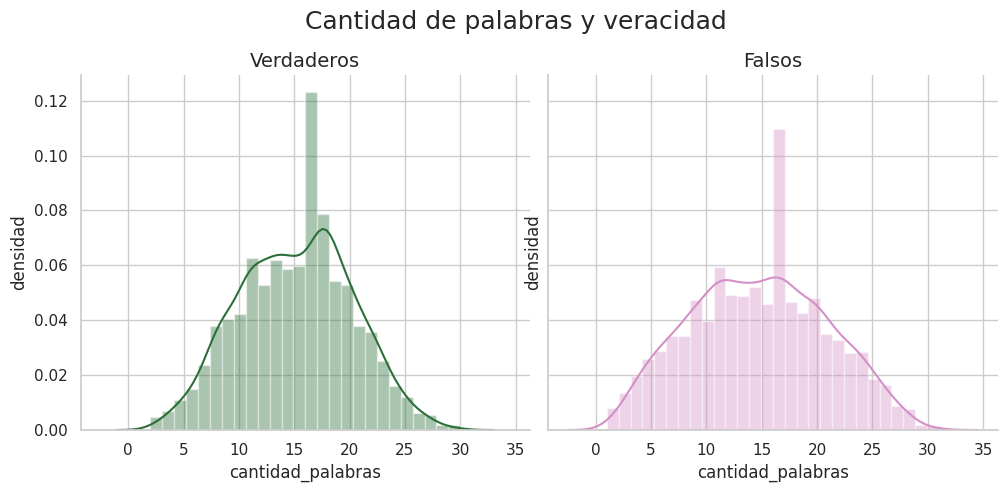

In [420]:
#Otro grafico para mostrar la veracidad a partir de la cantidad de palabras
g = sns.FacetGrid(text_simple, col="estado",height=5,hue='estado',palette='cubehelix')
g = g.map(sns.distplot, "cantidad_palabras").set(ylabel="densidad")
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Cantidad de palabras y veracidad', fontsize=18)
axes = g.axes.flatten()
axes[0].set_title("Verdaderos", fontsize=14)
axes[1].set_title("Falsos", fontsize=14)

plt.show()

### Números en el texto del tweet

In [421]:
tweets['has_numbers_name']= np.where(tweets['has_numbers']==1 ,'SI','NO')

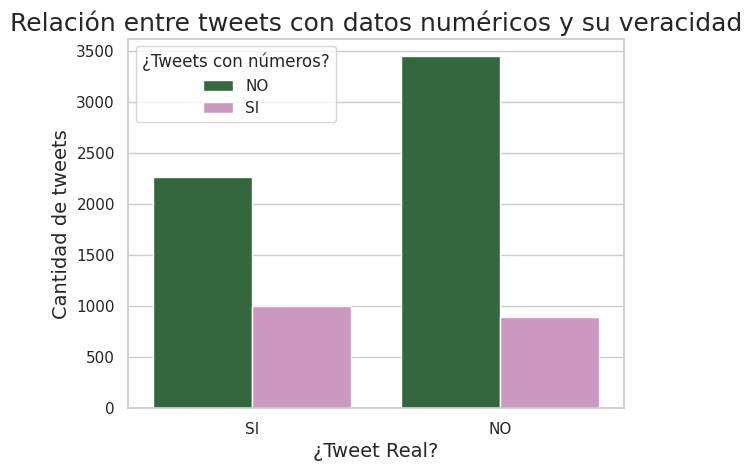

In [422]:
plot_tweets_numbers = sns.countplot(data=tweets,x="target_name", hue="has_numbers_name", palette="cubehelix")
plot_tweets_numbers.set_title("Relación entre tweets con datos numéricos y su veracidad", fontsize=18)
plot_tweets_numbers.set_xlabel("¿Tweet Real?", fontsize=14)
plot_tweets_numbers.set_ylabel("Cantidad de tweets", fontsize=14)
plot_tweets_numbers.legend(loc='upper left', title='¿Tweets con números?')

### Análisis de los keywords

In [500]:

keywords_null = (tweets['keyword'].isnull()).value_counts().iloc[::-1]
keywords_null = keywords_null.to_frame()
#Keywords nulas = True
keywords_null.rename(columns={"keyword":"keywods nulos"})


,keywods nulos
True,61
False,7552


[Text(0, 0.5, 'Cantidad tweets'),
 Text(0.5, 1.0, 'Cantidad de keywords nulas ')]

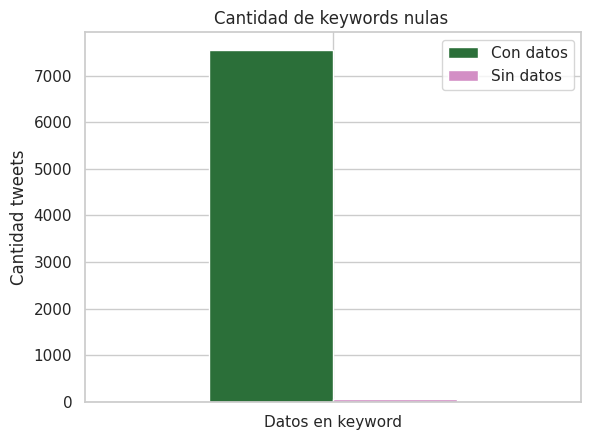

In [501]:
keywords_null = keywords_null.rename(columns={'keyword': 'Datos en keyword'}, index={True: 'Sin datos',False:'Con datos'})
keywords_null = pd.pivot_table(keywords_null, values='Datos en keyword',columns=['Sin datos','Con datos'])
g = keywords_null.plot.bar(rot = 0,cmap=cubehelix_map,use_index =True)
g.set(title = 'Cantidad de keywords nulas ',ylabel='Cantidad tweets')


In [423]:
# Agrupo por keyword y cuento la cantidad de apariciones que tienen y el promedio del target para sacar una suerte de "probabilidad de catastrofe"
probability = tweets.groupby('keywords').agg({'target':'mean'}).rename(columns={'target':'Probabilidad de Catastrofe'})
probability.sort_values('Probabilidad de Catastrofe', ascending=False).head(10)

,Probabilidad de Catastrofe
keywords,
debris,1.00
wreckage,1.00
derailment,1.00
outbreak,0.97
oil spill,0.97
typhoon,0.97
suicide bombing,0.97
suicide bomber,0.97
bombing,0.93


Text(0.5, 0, 'Keyword')

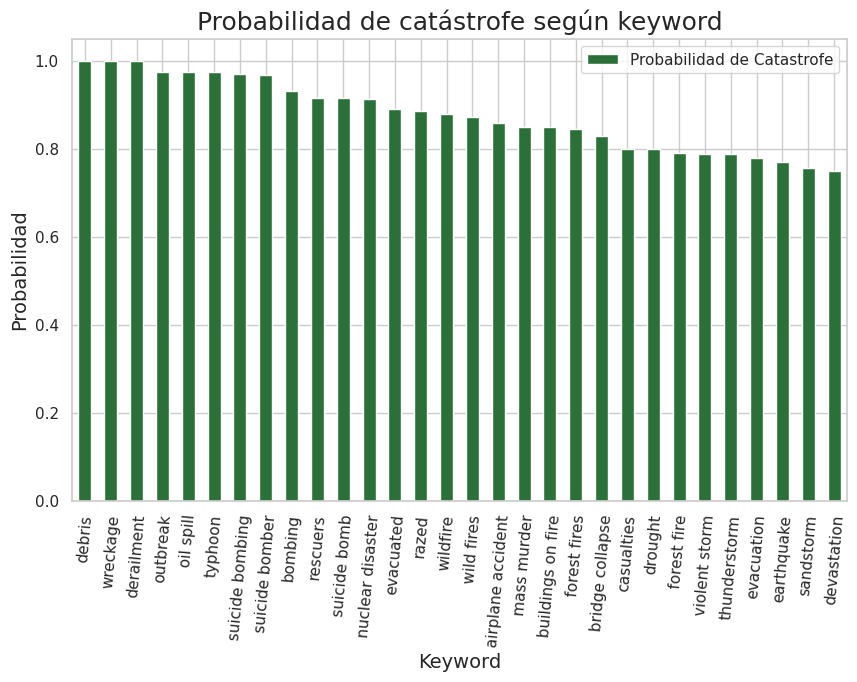

In [424]:
probability.sort_values('Probabilidad de Catastrofe', ascending=False).\
    head(30).\
    plot(kind='bar',figsize=(10,6),rot=85,cmap = cubehelix_map)
ax=plt.gca()
ax.set_title('Probabilidad de catástrofe según keyword', fontsize=18)
ax.set_ylabel('Probabilidad', fontsize=14)
ax.set_xlabel('Keyword', fontsize=14)

En este gráfico podemos observar cuales son las keywords que están más relacionadas a tweets verdaderos, por lo que palabras como debris (escombros), wreckage (destrucción), derailment (descarrilamiento), outbreak (brote, epidemia), oil spill (derrame de petróleo) y typhoon (tifón) tienen una gran probabilidad de estar siendo usadas en tweets que resultan ciertos.

### Análisis de los keywords relacionados con la veracidad del tweet

In [425]:
keyword_false = tweets[tweets["target"] == 0]["keyword"].value_counts()
keyword_true  = tweets[tweets["target"] == 1]["keyword"].value_counts()


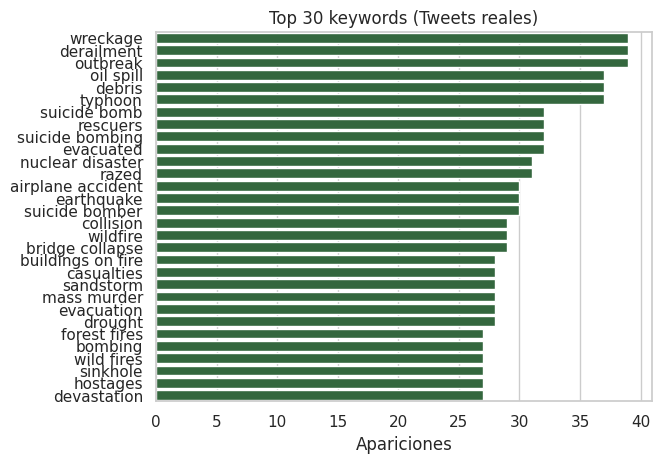

In [426]:
g = sns.barplot(x=keyword_true.head(30).values,y=keyword_true.head(30).index.str.replace('%20',' '),color = color_hex_arr[0],orient="h").\
    set(title = 'Top 30 keywords (Tweets reales)',xlabel='Apariciones')

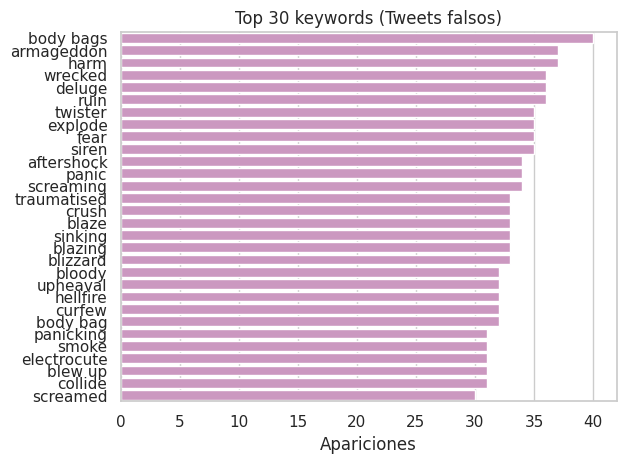

In [427]:

g = sns.barplot(x=keyword_false.head(30).values,y=keyword_false.head(30).index.str.replace('%20',' '),color=color_hex_arr[4],orient="h").\
    set(title = 'Top 30 keywords (Tweets falsos)',xlabel='Apariciones')

### Tendencia de los keywords a aparecer dentro de un tweet real/falso

[Text(0.5, 0, 'Apariciones'),
 Text(0.5, 1.0, 'Aparición de palabras por tipo de tweet')]

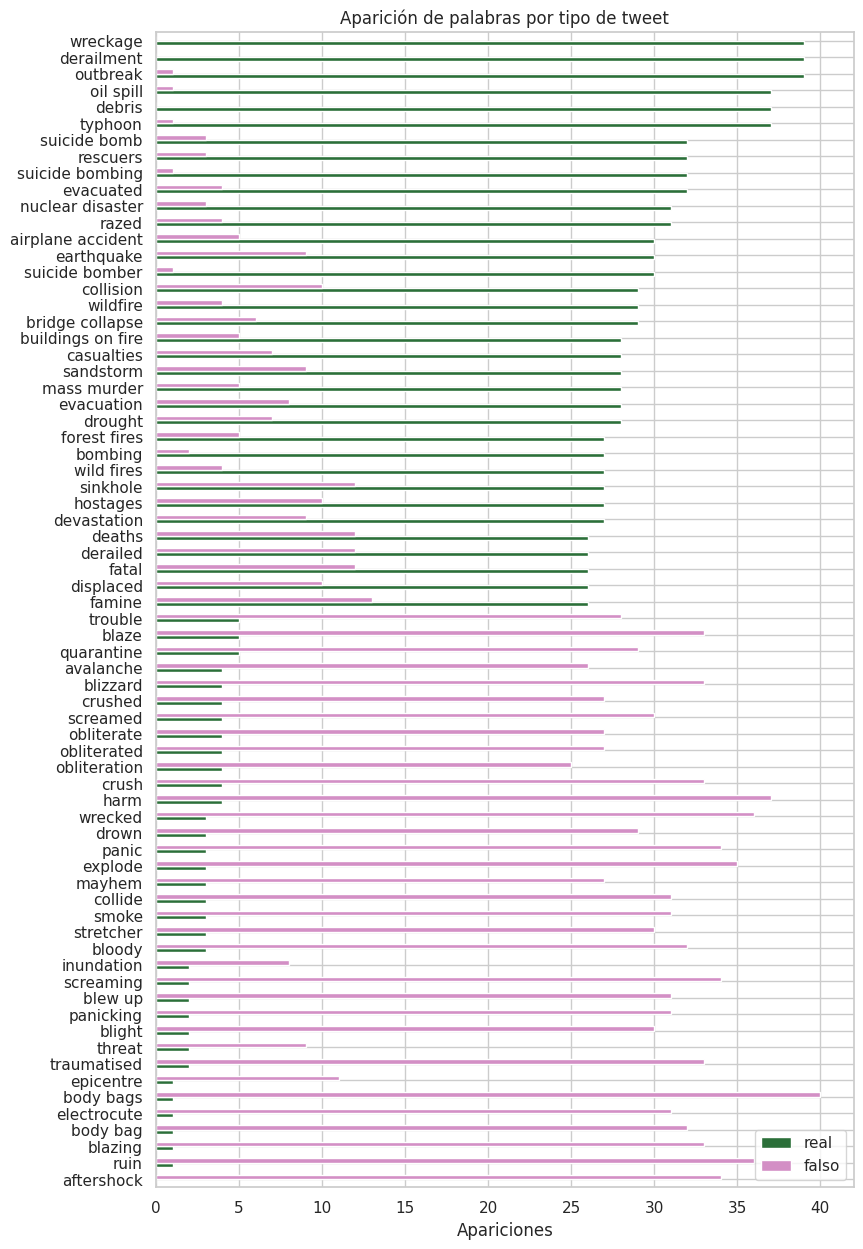

In [428]:

comparewords = pd.concat([keyword_true,keyword_false], axis=1)
comparewords.columns=['real','falso']
comparewords.index = comparewords.index.str.replace('%20',' ')
comparewords = comparewords.fillna(0)
comparewords = comparewords.sort_values(by=['real'])
comparewords_ct = pd.concat([comparewords.head(35),comparewords.tail(35)])

comparewords_ct.plot.barh(rot=0,figsize=(9,15),cmap = cubehelix_map).set(title='Aparición de palabras por tipo de tweet',xlabel='Apariciones')


### Análisis de sentimientos en el texto

In [429]:
sentiment_fakes = tweets[tweets.target == 0]['sentiment_score_compound']
sentiment_valid = tweets[tweets.target == 1]['sentiment_score_compound']

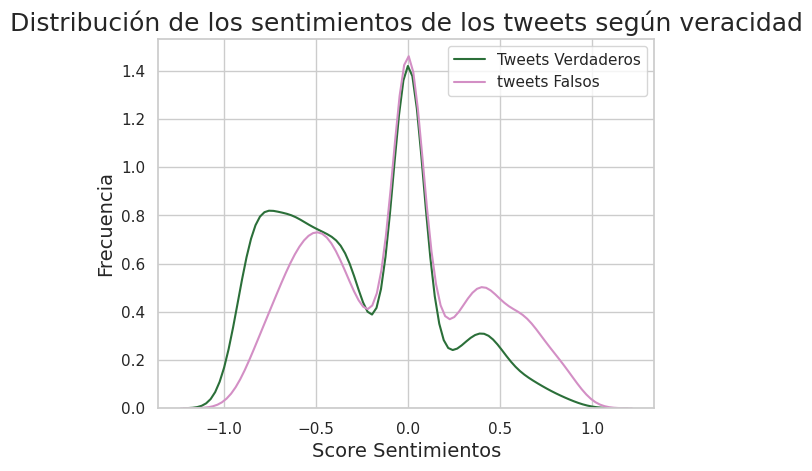

In [430]:
ax = sns.distplot( sentiment_valid , color=color_hex_arr[0], label="Tweets Verdaderos",hist=False)
ax = sns.distplot( sentiment_fakes , color=color_hex_arr[4], label="tweets Falsos",hist=False)
plt.legend()
ax.set_title("Distribución de los sentimientos de los tweets según veracidad", fontsize=18)
ax.set_xlabel("Score Sentimientos", fontsize=14)
ax.set_ylabel("Frecuencia", fontsize=14)
plt.show()

# los válidos tienen mas sentimientos negativos que positivos

Analizando el sentimiento detrás de los textos podemos ver que los tweets que resultan verdaderos suelen tener más sentimientos negativos que los que resultan falsos. Esto tiene sentido ya que si un tweet es verdadero es probable que exprese preocupación por la catástrofe. 

### Nube de palabras

Wordcloud para textos fake

In [431]:
# me quedo con todos los textos fakes
fakes = tweets[tweets.target == 0]
fakes_text = " ".join(review for review in fakes.normalized_text)

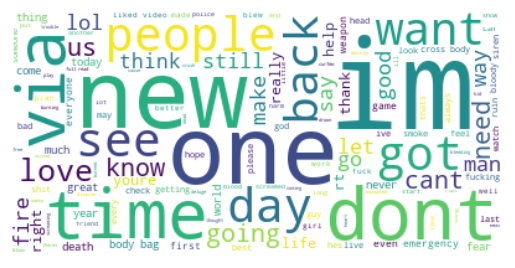

In [432]:
# Create and generate a word cloud image:
wordcloud_fake = WordCloud(max_font_size=100, max_words=800, margin=5, background_color="white").generate(fakes_text)

# Display the generated image:
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis("off")
plt.show()

En la nube de palabras asociada a los tweets falsos podemos ver que las palabra más frecuentes no tienen relación con una catástrofe pero tampoco podemos sacar
demasiadas conclusiones al respecto.
Aparece la palabra love lo que también sigue confirmando la presencia de sentimientos positivos.

Wordcloud para textos reales

In [433]:
# me quedo con todos los textos reales
reales= tweets[tweets.target == 1]
reales_text = " ".join(review for review in reales.normalized_text)

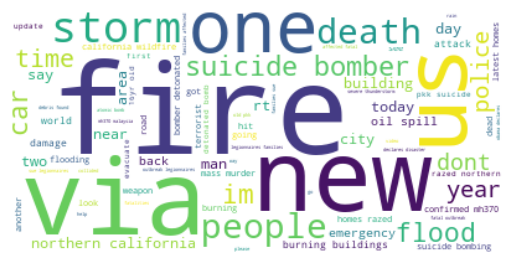

In [434]:
# Create and generate a word cloud image:
wordcloud_real = WordCloud(max_font_size=100, max_words=800, margin=5, background_color="white").generate(reales_text)

# Display the generated image:
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis("off")
plt.show()

En la nubre de palabras asociada a los tweets verdaderos podemos ver más presencia de palabras asociadas a catástrofes, ya que se mencionan feńomenos como storm,
flood, fire, suicide, bomber, police. La palabra people, via (quizás porque muchos son repost desde alguna otra app/pagina) y time se repite en ambas nubes.

### Relacion entre location y existencia en el texto. 
Busco la relación entre la location de un tweet y que esta exista en el texto 

[Text(0, 0.5, 'Cantidad tweets'),
 Text(0.5, 1.0, 'Correspondencia de location y su existencia en el texto*')]

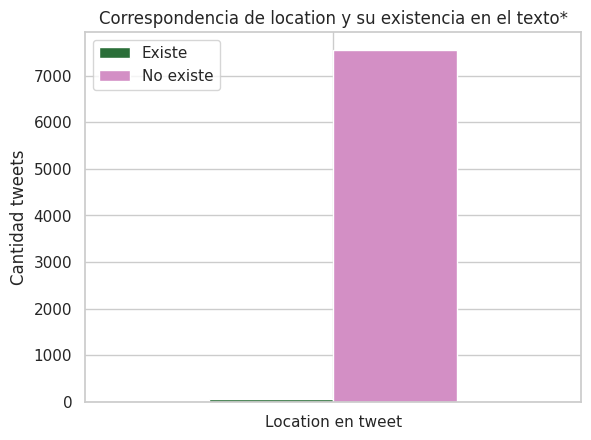

In [435]:
count_location = tweets['text_in_location'].value_counts().iloc[::-1]
count_location = count_location.to_frame()
count_location.columns= ['Location en tweet']
count_location = pd.pivot_table(count_location, values='Location en tweet',columns=['Existe','No existe'])

g = count_location.plot.bar(rot = 0,cmap=cubehelix_map,use_index =True)
g.set(title = 'Correspondencia de location y su existencia en el texto*',ylabel='Cantidad tweets')

##### *Por lo visto no tiene mucho sentido analizar si existe relacion entre la correspondencia de location y la veracidad del tweet por la gran diferencia que existe entre ambos. Es un dato irrelevante

### Analisis sobre la columna location

#### cantidad de locations nulas (none) vs locations con datos


In [504]:
locations_none = (tweets['location']=='None').value_counts().iloc[::-1]
locations_none = locations_none.to_frame()

locations_none.rename(columns={'location': 'tweet con location'})

,tweets con location
True,2533
False,5080


[Text(0, 0.5, 'Cantidad tweets'),
 Text(0.5, 1.0, 'Cantidad de nulos en location ')]

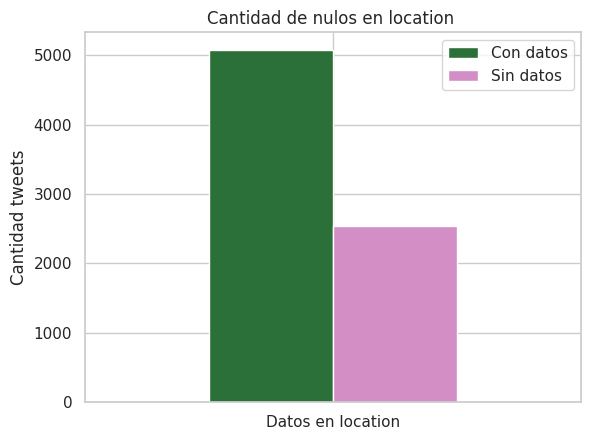

In [503]:

locations_none = locations_none.rename(columns={'location': 'Datos en location'}, index={True: 'Sin datos',False:'Con datos'})
locations_none = pd.pivot_table(locations_none, values='Datos en location',columns=['Sin datos','Con datos'])
g = locations_none.plot.bar(rot = 0,cmap=cubehelix_map,use_index =True)
g.set(title = 'Cantidad de nulos en location ',ylabel='Cantidad tweets')

#### Cantidad de tweets por location

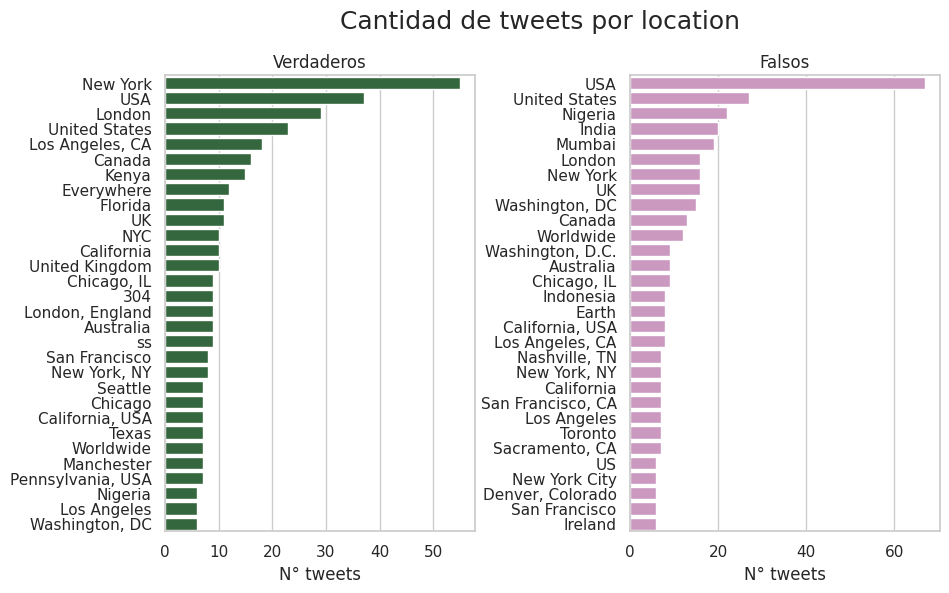

In [469]:
location_bar_true = tweets[(tweets["target"] == 0)&(tweets["location"]!= 'None')]['location'].value_counts()
location_bar_false = tweets[(tweets["target"] == 1)&(tweets["location"]!= 'None')]['location'].value_counts()

fig, ax =plt.subplots(1,2,figsize=(10,6))
sns.barplot(x=location_bar_true.head(30).values,y=location_bar_true.head(30).index.str.replace('%20',' '),color=color_hex_arr[0],ax=ax[0],orient="h").\
    set(title = 'Verdaderos',xlabel='N° tweets')
sns.barplot(x=location_bar_false.head(30).values,y=location_bar_false.head(30).index.str.replace('%20',' '),color=color_hex_arr[4],ax=ax[1],orient="h").\
    set(title = 'Falsos',xlabel='N° tweets')
fig.subplots_adjust(top=0.87,wspace = 0.5)
fig.suptitle('Cantidad de tweets por location', fontsize=18)
fig.show()